### Install binance package

Install pandas > 1.1.0 to use FixedForwardWindowIndexer

In [1]:
!pip install pandas==1.2.3

     |████████████████████████████████| 9.9 MB 1.6 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Successfully uninstalled pandas-1.0.3


In [2]:
!pip install python-binance

     |████████████████████████████████| 3.1 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 279 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 495 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 248 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 721 kB 1.7 MB/s eta 0:00:01
ERROR: autobahn 21.3.1 has requirement cryptography>=3.4.6, but you'll have cryptography 2.9.2 which is incompatible.


In [3]:
!pip install python-dotenv

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
    
restartkernel()

### Remember to restart Kernel after installling binance package !!

Create an .env File with your Binance Credentials:
```
 export BINANCE_KEY=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
 export BINANCE_SECRET=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
```

In [1]:
%load_ext dotenv
%dotenv

In [53]:
# IMPORTS
import pandas as pd
import math
import os.path
import os
import time
import numpy as np
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = os.getenv('BINANCE_KEY')    #Enter your own API-key here
binance_api_secret = os.getenv('BINANCE_SECRET')  #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "15m": 15, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df



In [117]:
binance_symbols = ["BTCEUR", "ETHEUR", "ADAEUR"]
for symbol in binance_symbols:
    get_all_binance(symbol,Client.KLINE_INTERVAL_1MINUTE, save = True)
for symbol in binance_symbols:
    get_all_binance(symbol,Client.KLINE_INTERVAL_15MINUTE, save = True)
for symbol in binance_symbols:
    get_all_binance(symbol,Client.KLINE_INTERVAL_1DAY, save = True)

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!


In [121]:
btc=pd.read_csv("BTCEUR-1m-data.csv")
btc.tail()
interval=60*24

In [119]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib

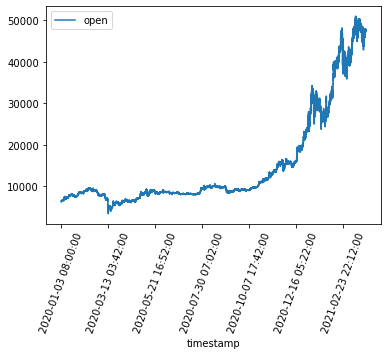

In [120]:
btc.plot(x="timestamp", y="open",rot=70)

In [122]:
#data = btc[(btc['timestamp'] > '2021-03-20 00:00:00') ]
# last 30 days (in 15min chunks)
data = btc[-interval*10:] 
data

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
632791,2021-03-18 18:13:00,49394.66,49431.52,49332.37,49332.37,4.825462,1616091239999,238253.268734,200,1.418540,70060.257132,0
632792,2021-03-18 18:14:00,49329.78,49362.72,49314.00,49321.58,2.926054,1616091299999,144342.806906,151,2.013876,99352.965967,0
632793,2021-03-18 18:15:00,49321.19,49322.00,49222.88,49234.96,7.424191,1616091359999,365930.692801,401,2.818391,138937.450363,0
632794,2021-03-18 18:16:00,49222.78,49370.49,49222.77,49353.70,4.921923,1616091419999,242662.426719,230,4.017836,198087.867493,0
632795,2021-03-18 18:17:00,49368.47,49391.60,49312.04,49348.69,4.293692,1616091479999,211926.092375,184,2.595992,128157.222709,0
...,...,...,...,...,...,...,...,...,...,...,...,...
647186,2021-03-28 18:06:00,47429.80,47456.54,47429.80,47447.85,0.573109,1616954819999,27192.813599,87,0.307235,14578.314662,0
647187,2021-03-28 18:07:00,47445.72,47456.11,47412.34,47419.91,1.378658,1616954879999,65403.674230,113,0.410787,19492.749269,0
647188,2021-03-28 18:08:00,47415.50,47418.10,47387.00,47394.90,1.246859,1616954939999,59102.943337,136,0.331134,15695.348892,0
647189,2021-03-28 18:09:00,47394.90,47407.56,47343.47,47358.21,3.357992,1616954999999,159033.739874,184,0.500800,23724.186245,0


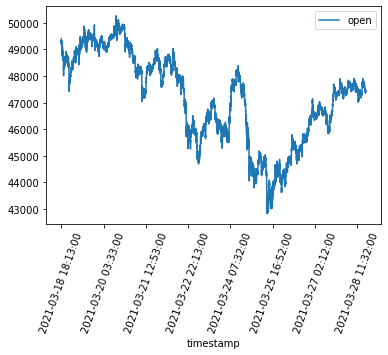

In [123]:
data.plot(x="timestamp", y="open",rot=70)

In [124]:
pd.options.mode.chained_assignment = None  # default='warn'

In [125]:
data['datetime'] = pd.to_datetime(data['timestamp'])
data['dates'] = data['datetime'].dt.date
data

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,datetime,dates
632791,2021-03-18 18:13:00,49394.66,49431.52,49332.37,49332.37,4.825462,1616091239999,238253.268734,200,1.418540,70060.257132,0,2021-03-18 18:13:00,2021-03-18
632792,2021-03-18 18:14:00,49329.78,49362.72,49314.00,49321.58,2.926054,1616091299999,144342.806906,151,2.013876,99352.965967,0,2021-03-18 18:14:00,2021-03-18
632793,2021-03-18 18:15:00,49321.19,49322.00,49222.88,49234.96,7.424191,1616091359999,365930.692801,401,2.818391,138937.450363,0,2021-03-18 18:15:00,2021-03-18
632794,2021-03-18 18:16:00,49222.78,49370.49,49222.77,49353.70,4.921923,1616091419999,242662.426719,230,4.017836,198087.867493,0,2021-03-18 18:16:00,2021-03-18
632795,2021-03-18 18:17:00,49368.47,49391.60,49312.04,49348.69,4.293692,1616091479999,211926.092375,184,2.595992,128157.222709,0,2021-03-18 18:17:00,2021-03-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647186,2021-03-28 18:06:00,47429.80,47456.54,47429.80,47447.85,0.573109,1616954819999,27192.813599,87,0.307235,14578.314662,0,2021-03-28 18:06:00,2021-03-28
647187,2021-03-28 18:07:00,47445.72,47456.11,47412.34,47419.91,1.378658,1616954879999,65403.674230,113,0.410787,19492.749269,0,2021-03-28 18:07:00,2021-03-28
647188,2021-03-28 18:08:00,47415.50,47418.10,47387.00,47394.90,1.246859,1616954939999,59102.943337,136,0.331134,15695.348892,0,2021-03-28 18:08:00,2021-03-28
647189,2021-03-28 18:09:00,47394.90,47407.56,47343.47,47358.21,3.357992,1616954999999,159033.739874,184,0.500800,23724.186245,0,2021-03-28 18:09:00,2021-03-28


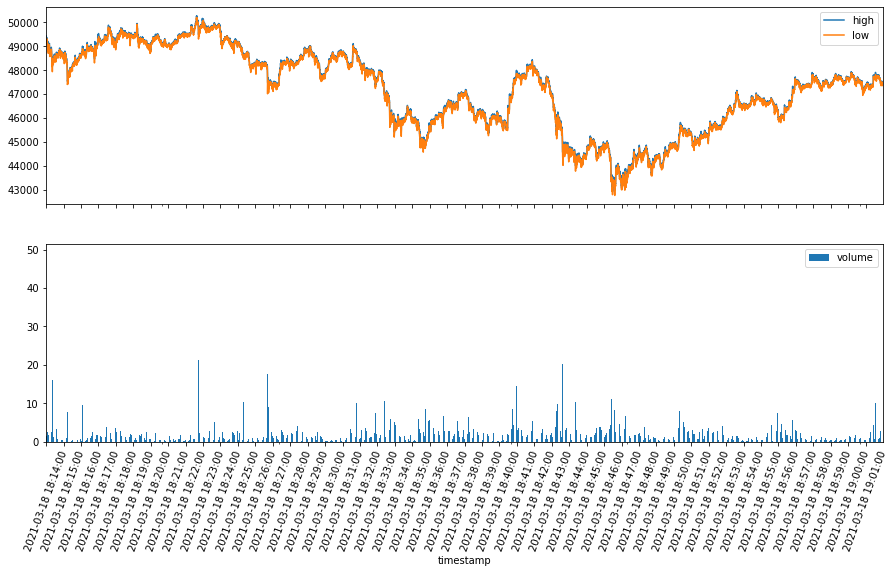

In [126]:

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
data.plot(x="timestamp", y=["high","low"], rot= 70, ax=ax[0])
data.plot.bar(x="timestamp", y="volume", rot= 70, ax=ax[1])
#ax[0].plot(data.timestamp, data.high, rot=70)
#ax[1].bar(data.timestamp, data.volume, width=1/(5*len(data.timestamp)))
#fig.autofmt_xdate()
#ax[1].set_xticklabels(data.dates., rotation=70)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(300))
#ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d"))

plt.show()

In [127]:
def max_high(values):
    ma = max(values)
    return ma

For each row calculate the max value for the next 24h

In [128]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=interval)
data['maxin24h'] = data['high'].rolling(window=indexer, min_periods=1).apply( max_high)
data

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,datetime,dates,maxin24h
632791,2021-03-18 18:13:00,49394.66,49431.52,49332.37,49332.37,4.825462,1616091239999,238253.268734,200,1.418540,70060.257132,0,2021-03-18 18:13:00,2021-03-18,49877.00
632792,2021-03-18 18:14:00,49329.78,49362.72,49314.00,49321.58,2.926054,1616091299999,144342.806906,151,2.013876,99352.965967,0,2021-03-18 18:14:00,2021-03-18,49877.00
632793,2021-03-18 18:15:00,49321.19,49322.00,49222.88,49234.96,7.424191,1616091359999,365930.692801,401,2.818391,138937.450363,0,2021-03-18 18:15:00,2021-03-18,49877.00
632794,2021-03-18 18:16:00,49222.78,49370.49,49222.77,49353.70,4.921923,1616091419999,242662.426719,230,4.017836,198087.867493,0,2021-03-18 18:16:00,2021-03-18,49877.00
632795,2021-03-18 18:17:00,49368.47,49391.60,49312.04,49348.69,4.293692,1616091479999,211926.092375,184,2.595992,128157.222709,0,2021-03-18 18:17:00,2021-03-18,49877.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647186,2021-03-28 18:06:00,47429.80,47456.54,47429.80,47447.85,0.573109,1616954819999,27192.813599,87,0.307235,14578.314662,0,2021-03-28 18:06:00,2021-03-28,47456.54
647187,2021-03-28 18:07:00,47445.72,47456.11,47412.34,47419.91,1.378658,1616954879999,65403.674230,113,0.410787,19492.749269,0,2021-03-28 18:07:00,2021-03-28,47456.11
647188,2021-03-28 18:08:00,47415.50,47418.10,47387.00,47394.90,1.246859,1616954939999,59102.943337,136,0.331134,15695.348892,0,2021-03-28 18:08:00,2021-03-28,47418.10
647189,2021-03-28 18:09:00,47394.90,47407.56,47343.47,47358.21,3.357992,1616954999999,159033.739874,184,0.500800,23724.186245,0,2021-03-28 18:09:00,2021-03-28,47407.56


### Plot High and maxin24h 

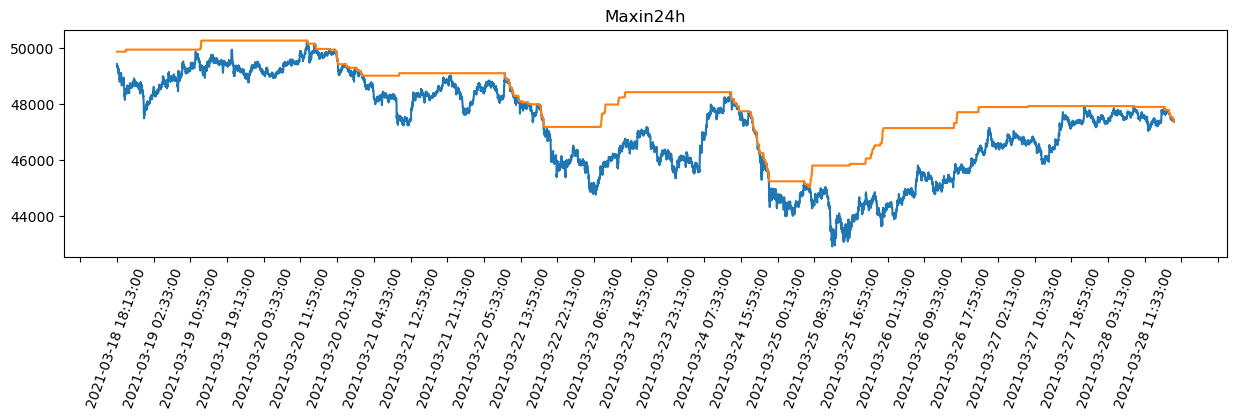

In [129]:
import matplotlib.dates as mdates
plt.close()

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,3), dpi=100)
plt.title('Maxin24h')
ax.plot(data["timestamp"], data["high"])
ax.plot(data["timestamp"], data["maxin24h"])
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
plt.xticks(rotation=70)
plt.show()

now for each row calculate the possible gain if it had to be sold in the next 24h

In [169]:
gain=.05

In [172]:
data['gain']= data['maxin24h']-data['low']
data['good'] = data.apply (lambda row: row['low'] if row['gain']>=row['low']*gain else np.nan, axis=1)
data['bad'] = data.apply (lambda row: row['low'] if row['gain']<row['low']*gain else np.nan, axis=1)

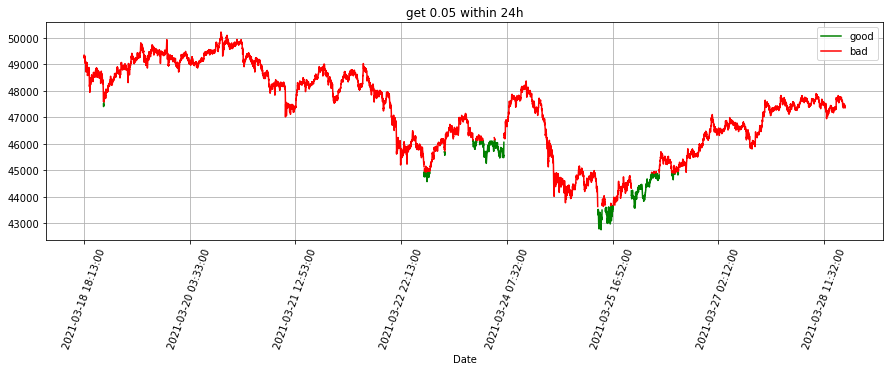

In [179]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,4))
data.plot(x="timestamp", y='good',  ax=ax, color='green',rot= 70)
data.plot(x="timestamp", y='bad',  ax=ax, color='red',rot= 70)
plt.title(f"get {gain} within 24h")
plt.xlabel("Date")
plt.grid()
plt.show()

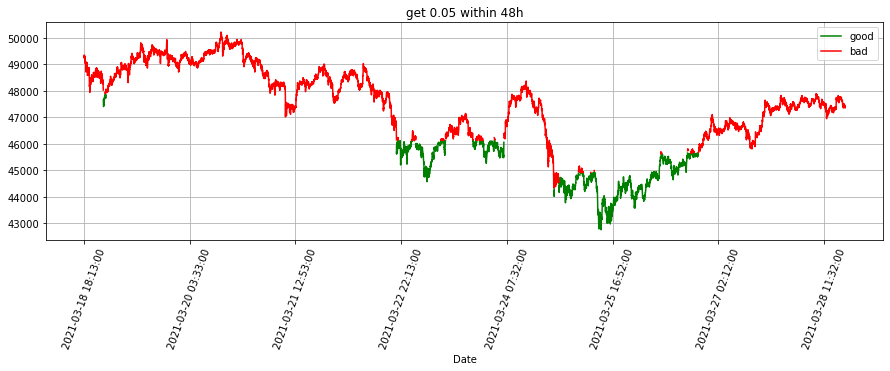

In [184]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=interval*2)
data['maxin24h'] = data['high'].rolling(window=indexer, min_periods=1).apply( max_high)

data['gain']= data['maxin24h']-data['low']
data['good'] = data.apply (lambda row: row['low'] if row['gain']>=row['low']*gain else np.nan, axis=1)
data['bad'] = data.apply (lambda row: row['low'] if row['gain']<row['low']*gain else np.nan, axis=1)

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,4))
data.plot(x="timestamp", y='good',  ax=ax, color='green',rot= 70)
data.plot(x="timestamp", y='bad',  ax=ax, color='red',rot= 70)
plt.title(f"get {gain} within {int(interval*2/60)}h")
plt.xlabel("Date")
plt.grid()
plt.show()

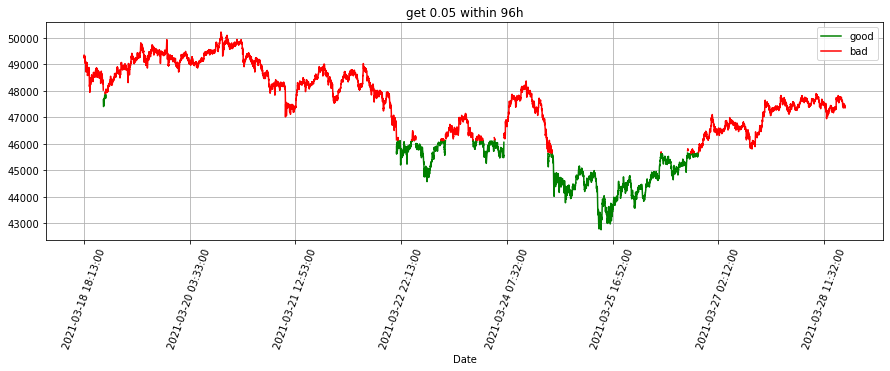

In [186]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=interval*4)
data['maxin24h'] = data['high'].rolling(window=indexer, min_periods=1).apply( max_high)

data['gain']= data['maxin24h']-data['low']
data['good'] = data.apply (lambda row: row['low'] if row['gain']>=row['low']*gain else np.nan, axis=1)
data['bad'] = data.apply (lambda row: row['low'] if row['gain']<row['low']*gain else np.nan, axis=1)

fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(15,4))
data.plot(x="timestamp", y='good',  ax=ax, color='green',rot= 70)
data.plot(x="timestamp", y='bad',  ax=ax, color='red',rot= 70)
plt.title(f"get {gain} within {int(interval*4/60)}h")
plt.xlabel("Date")
plt.grid()
plt.show()